<a href="https://colab.research.google.com/github/ludutram/LucianaDutra/blob/master/Atividade_Aula_3_RL_UFG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
np.set_printoptions(linewidth=np.inf)

## OpenAI Gym

O [OpenAI Gym](https://gym.openai.com/) visa fornecer um benchmark fácil de configurar com uma ampla variedade de ambientes diferentes. O objetivo é padronizar como os ambientes são definidos nas publicações de pesquisa de IA para que as pesquisas publicadas se tornem mais facilmente reprodutíveis. O projeto pretende fornecer ao usuário uma interface simples.


A peça central do Gym é o ambiente, que define o problema em que seu algoritmo de reforço atuará.

O ambiente possui alguns métodos básicos:

- **reset**: reinicia o ambiente ao seu estado inicial
- **step**: Dá um passo adiante na simulação do ambiente
  - retorna uma observação, a recomensa, um sinalizador de término do episódio, e informações adicionais (caso relevantes).
- **render**: renderiza o ambiente para visualização de seu estado atuado (Não utilizado neste notebook)
  - retorna apenas a observação inicial.


Abaixo temos um ambiente básico para um Processo de Decisão de Markov utilizando 5 estados e 2 ações possíveis.

In [3]:
import gym
from gym import spaces

N = 5  #5 estados
A = 2  #2 ações
class MarkovDecisionProcess(gym.Env):
    def __init__(self):    
        self.N = N
        self.states = [s for s in range(N)]
        self.transition_matrix = [
            [
                [0.00, 0.25, 0.25, 0.25, 0.25],
                [0.00, 0.00, 1/3, 1/3, 1/3],
                [0.00, 0.00, 0.00, 0.50, 0.50],
                [0.00, 0.00, 0.00, 0.00, 1.00],
                [0.00, 0.00, 0.00, 0.00, 0.00]],
            [
                [0.00, 1.00, 0.00, 0.00, 0.00],
                [0.00, 0.00, 1.00, 0.00, 0.00],
                [0.00, 0.00, 0.00, 1.00, 0.00],
                [0.00, 0.00, 0.00, 0.00, 1.00],
                [0.00, 0.00, 0.00, 0.00, 0.00]],
            ]
        self.reward_function = [0.0, 0.0, 0.0, 0.0, 1.0]
        
        self.observation_space = spaces.Discrete(N)
        self.action_space = spaces.Discrete(A)

        self.starting_state = 0
        self.current_state = 0
        self.timestep = 0
        self.terminal_states = [4]

    def step(self, action):
        
        next_state = np.random.choice(self.states, p=self.transition_matrix[action][self.current_state])
        obs = next_state
        reward = self.reward_function[next_state]
        done = (next_state in self.terminal_states)
        self.timestep += 1
        info = {"t": self.timestep}
        self.current_state = next_state

        return obs, reward, done, info

    def reset(self):
        self.timestep = 0
        self.current_state = self.starting_state
        obs = self.starting_state
        return obs



Ambientes no OpenAI Gym são facilmente criados por um nome, e ambientes customizados podem ser registrados para compartilhar desta facilidade.

In [4]:
gym.envs.register(
     id='MDP-v0',
     entry_point="__main__:MarkovDecisionProcess",
)

A biblioteca Gym nos permite consultar alguns atributos dos ambientes, em especial os espaços de ação e observação:

In [6]:
env = gym.make("MDP-v0")
print(env.action_space)
print(env.observation_space)

Discrete(2)
Discrete(5)


Espaços podem assumir diversas formas, os mais comuns são:

- **Box**: para espaços multidimensionais e contínuos (imagens caem nesta categoria)
- **Discrete**: para espaços discretos
- **Dict**: para espaços customizados (geralmente multiagentes)
- **Text**: para espaços textuais nao numéricos



-----------

## Fluxo de Interação

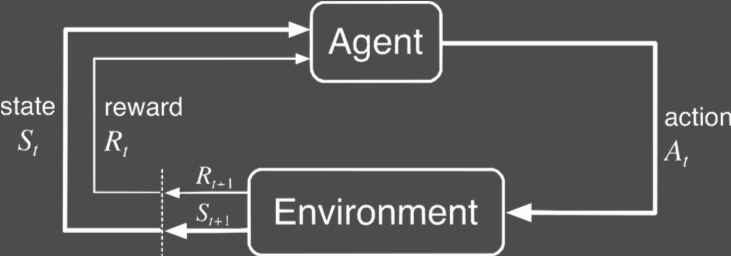

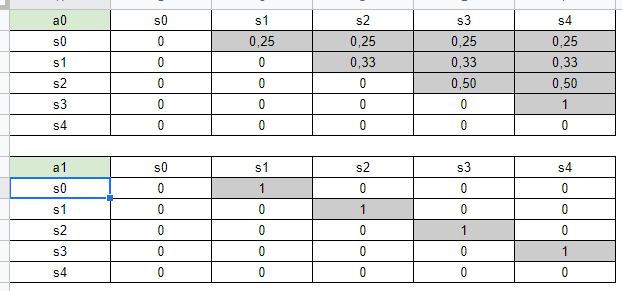

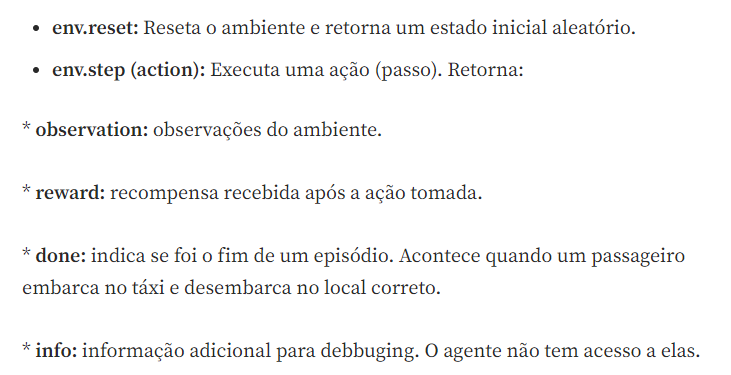

O fluxo de interação entre um agente e um ambiente durante um episódio é codificado da seguinte forma:

In [9]:
# Ciclo de Interação Agente-Ambiente

states = []
actions = []
rewards = []

s = env.reset()
states.append(s)
rewards.append(0)
done = False
while not done:

    a = env.action_space.sample() # Escolhendo ação aleatória
    next_s, r, done, info = env.step(a)
    
    states.append(next_s)
    actions.append(a)
    rewards.append(r)

    s = next_s

env.close() # Chamado somente quando o ambiente não será mais usado (será necessário outro env.make)
print(states)
print(actions)
print(rewards)



[0, 1, 2, 3, 4]
[1, 1, 1, 0]
[0, 0.0, 0.0, 0.0, 1.0]


## Cálculo do Retorno

Faça o cálculo do retorno e execute-o na trajetória adquirida acima com `GAMMA = 0.9`


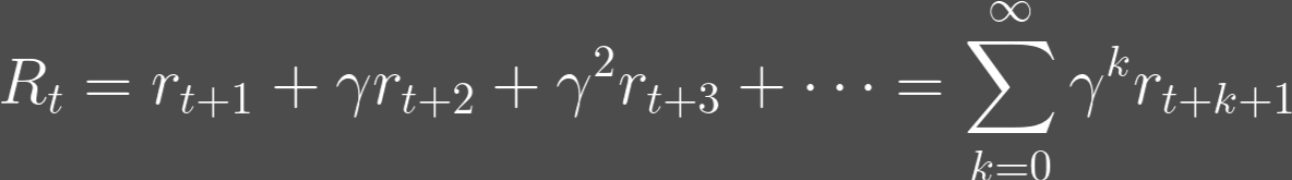

Exemplo:
Estados [ 0, 1, 2, 3, 4]

R(S4|S0) = r(S1|S0) + gamma x r(S2|S0) + gamma^2 x r(S3|S0) + gamma^3 x r(S4|S0)

R(S4|S0) = 0 + 0,9*0 + 0,9 x 0,9 x 0 + 0,9 x 0,9 x 0,9 x 1

R(S4|S0) = 0,72900


In [10]:
# Cálculo do Retorno
def get_R(rewards, gamma=0.9):
  R = 0
  for i, r in enumerate(rewards):
    R += (gamma**i)*r
  return R

get_R(rewards[1:])


0.7290000000000001

## Funções de Valor

Dado o ambiente demonstrado acima, calcule manualmente as funções de valor para estado e estado-ação ótimas.

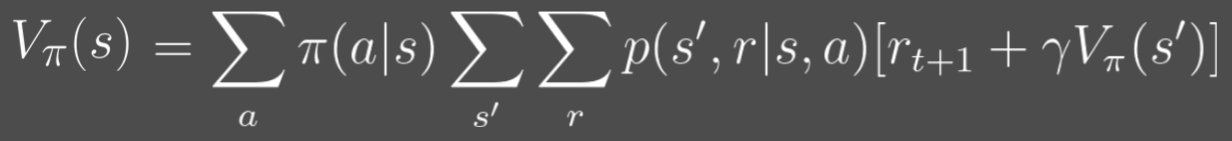

Q (s0,a0) = r0 { [p(s0|s0,a0) x (r0 +  γ x V(s0)] + [p(s1|s0,a0) x (r0 +  γ x V(s1)] + [p(s0|s2,a0) x (r0 +  γ x V(s2)] + [p(s3|s0,a0) x (r0 +  γ x V(s3)] + [p(s4|s0,a0) x (r0 +  γ x V(s4)]




In [11]:
V = np.random.randn(N)                  # V(s) valor estado
Q = np.random.rand(N, A)                # Q(s, a) valor estado ação

r_np = np.array(env.reward_function)
T = np.array(env.transition_matrix)
eps = 1e-10                              #constante bem pequena
gamma = 0.9

done = False
#count = 0
while not done:
  old_V = V
  for i in range(len(V)):
    Q[i] = (T[:,i,:]*(r_np + gamma*V)).sum(axis=1)  # T(a, s, s_prime) 
  V = Q.mean(axis=1)

  #count += 1
  if np.linalg.norm(old_V - V) <= eps:    #calcula a distância euclidiana entre old_V e V
    done = True

# Função de valor ótima
V_otima = Q.max(axis=1)
print(V_otima)

#Função de Valor para Política Aleatória
V_random = Q.mean(axis=1)
print(V_random)


[0.87925    0.91083333 0.95       1.         0.        ]
[0.831875   0.87166667 0.925      1.         0.        ]


## Fluxo para múltiplos episódios

Utilizando o fluxo de interação agente-ambiente e o cálculo de retorno, atualize a célula a seguir para que ela execute vários episódios fazendo o cálculo do retorno para cada um deles.

Utilizando os retornos, calcule funções de valor (lista e matriz) para estados e pares estado-ação que sejam a média dos retornos de todos os episódios.

Execute o algoritmo mostrando no final o valor convergido pelas médias e compare com as funções de valor ótima e de política aleatória.

In [24]:
# Interação de vários episódios
env = gym.make("MDP-v0")

N_EPISODES = 10
GAMMA = 0.9

def run_episode():
  ## trecho modificado a partir do código fornecido na quinta célula de código
  # Ciclo de Interação Agente-Ambiente

  states = []                                              #lista vazia de estados
  actions = []                                             #lista vazia de ações
  rewards = []                                             #lista vazia de recompensas

  s = env.reset()           
  done = False
  while not done:

      states.append(s)                                    # acrescenta estados  na variável estados                       
      a = env.action_space.sample()                       # Escolhe uma ação aleatória
      actions.append(a)                                   # acrescenta ações  na variável ações  
      s, r, done, info = env.step(a)                      #executa uma ação
      rewards.append(r)                                   # acrescenta recompensas  na variável recompensa 
  
  return states, actions, rewards

R_matrix = np.zeros((N, A, N_EPISODES))                   #inicializando a matriz de recompensas, Número_linhas = N e Número_colunas 
R_matrix[N-1] += 1                                          
for ep in range(N_EPISODES):
  states, actions, rewards = run_episode()                #roda um episódio
  for i, (s, a) in enumerate(zip(states, actions)):
    R_matrix[s, a, ep] = get_R(rewards[i:], GAMMA)        #monta a matriz retorno = recompensas * gamma

count_matrix = (R_matrix != 0).sum(axis=-1)
Q = R_matrix.sum(axis=2)/count_matrix                     #matriz com a média dos retornos de todos os episódios.
V = Q.mean(axis=1)                                        #cálcula a média dos valores de Q

print(states)
print(actions)
print(rewards)

print(R_matrix)

print(Q)

print(V)


env.close()


[0, 1, 2]
[1, 1, 0]
[0.0, 0.0, 1.0]
[[[1.    0.    0.729 0.    0.    0.729 1.    0.    0.81  0.   ]
  [0.    0.729 0.    0.729 0.81  0.    0.    0.81  0.    0.81 ]]

 [[0.    0.81  0.    0.    0.    0.    0.    0.9   0.    0.   ]
  [0.    0.    0.81  0.81  0.9   0.81  0.    0.    0.    0.9  ]]

 [[0.    0.    0.    0.9   1.    0.9   0.    1.    0.9   1.   ]
  [0.    0.9   0.9   0.    0.    0.    0.    0.    0.    0.   ]]

 [[0.    1.    0.    0.    0.    1.    0.    0.    0.    0.   ]
  [0.    0.    1.    1.    0.    0.    0.    0.    1.    0.   ]]

 [[1.    1.    1.    1.    1.    1.    1.    1.    1.    1.   ]
  [1.    1.    1.    1.    1.    1.    1.    1.    1.    1.   ]]]
[[0.8536 0.7776]
 [0.855  0.846 ]
 [0.95   0.9   ]
 [1.     1.    ]
 [1.     1.    ]]
[0.8156 0.8505 0.925  1.     1.    ]


--------
Agora, faça uma simples função onde, dado um estado e a função de valor estado-ação, ela retorna a ação que maximize o Q(s,a).

In [ ]:
# Função que sempre escolhe a melhor ação dada uma função Qsa
def policy(s, Q):
  return np.argmax(Q[s])

for s in range(N-1):
  print(f'best action from state {s} is {policy(s, Q)}')


best action from state 0 is 0
best action from state 1 is 0
best action from state 2 is 0
best action from state 3 is 0


Copie o código de múltiplos episódios executado anteriormente, porém, faça com que a ação escolhida seja a ação que maximize Q(s,a).

Obs: Lembre-se de atualizar Q(s,a) com as médias dos retornos a cada episódio.

In [ ]:
# Reutilizando o algoritmo acima, agora escolhendo sempre a melhor ação
import pdb
# Interação de vários episódios
env = gym.make("MDP-v0")

N_EPISODES = 10000
GAMMA = 0.9

def run_policy_episode(Q):
  ## trecho modificado a partir do código fornecido na quinta célula de código
  # Ciclo de Interação Agente-Ambiente

  states = []
  actions = []
  rewards = []

  s = env.reset()
  done = False
  while not done:

      states.append(s)
      a = policy(s, Q) # Escolhendo ação seguindo politica baseada em Q
      actions.append(a)
      
      s, r, done, info = env.step(a)
      rewards.append(r)
  
  return states, actions, rewards

#Q = 0.1*np.random.rand(N - 1, A) + 10
Q = np.zeros((N - 1, A)) + 100
count = np.zeros((N - 1, A))
for ep in range(N_EPISODES):
  states, actions, rewards = run_policy_episode(Q)
  V = Q.max(axis=-1)
  for s, a, r in zip(states, actions, rewards):
    count[s,a] += 1
    alpha = 1/count[s,a]
    #pdb.set_trace()
    Q[s, a] = (1 - alpha)*Q[s,a] + alpha*(r + GAMMA*V[s])

print(count)
print(Q)


env.close()


[[6158. 3842.]
 [3181. 2156.]
 [3025. 1736.]
 [2941. 2940.]]
[[40.99339848 40.99324921]
 [43.43266345 43.43093965]
 [44.38122623 44.38200689]
 [47.89304691 47.8943354 ]]


## Modelagem

Imagine a seguinte situação:

Um navio pesqueiro automatizado decide suas ações baseando-se na quantidade de peixes detectados na região por imagens de satélite. A quantidade de peixes varia entre **nenhum**, **baixa**, **media**, e **alta**. Ao ler estas informações, o computador do navio precisa decidir se irá **pescar** ou **não**. 

Lembrando que **pescar** custa combustível (ou seja, dinheiro), portanto não é prudente **pescar** a todo momento. Ao **pescar** com qualquer nível de peixes, existem 3/4 de chance da população diminuir para um nível anterior e 1/4 de permanecer no mesmo nível. **Não pescar** também possui seu custo com pessoal, mas são menores que os de **pescar** sem pegar nada. Ao **não pescar**, os peixes são permitidos de reproduzir e aumentar sua população sendo que de **nenhum** para **baixa** é 100% de chance, de **baixa** para **média** há 75% dechance, e de **média** para **alta** há 60% de chance. Ao **pescar** com o nível **baixo**, os lucros da pesca passam levemente dos custos de operação do navio. Ao **pescar** com o nível **médio** os lucros cobrem o custo de operação do barco duas vezes, ao **pescar** em nível **alto**, os lucros são dobrados em relação aos de pescar em nível médio.

O navio opera por **12 meses** tomando decisões de pesca a cada mês. O objetivo é, portanto, maximizar os lucros ao longo do ano. Vale lembrar que, em janeiro, devido ao clima, nunca há peixes detectados pelo satélite.

Altere o código do ambiente na célula a seguir (o mesmo código utilizado ao longo deste notebook) para que ele reflita o ambiente da imagem.

Em seguida, copie o código de execução para vários episódios e execute-o no novo ambiente calculando seus retornos e funções de valor executando ações que maximizem Q(s,a). Observe a função de valor para a qual o algoritmo converge avaliando se faz sentido, dadas as dinâmicas do problema.

Obs: Lembre-se de comentar as alterações no código do ambiente para facilitar a leitura.

In [ ]:
import gym
from gym import spaces

class MarkovDecisionProcessv1(gym.Env):
    def __init__(self):    
        self.N = 4 # numero de estados
        self.A = 2 # numero de ações
        self.states = [s for s in range(self.N)]
        self.transition_matrix = [
            [
                # chance de mudar (ou não) o nível de peixe dado que houve pesca
                [1.0, 0.0, 0.0, 0.0],
                [3/4, 1/4, 0.0, 0.0],
                [0.0, 3/4, 1/4, 0.0],
                [0.0, 0.0, 3/4, 1/4]],
            [
                # chance de mudar (ou não) o nível de peixe dado que não houve pesca
                [0.0, 1.0, 0.0, 0.0],
                [0.0, 1/4, 3/4, 0.0],
                [0.0, 0.0, 2/5, 3/5],
                [0.0, 0.0, 0.0, 1.0]],
            ]
        self.reward_function = [
                # custo por pescar em diferentes níveis de peixe
                [-1.0, 0.1, 1.0, 2.0],

                # custo por não pescar em diferentes níveis de peixe
                [-0.5, -0.5, -0.5, -0.5],
            ]

        self.observation_space = spaces.Discrete(self.N)
        self.action_space = spaces.Discrete(self.A)

        self.reset()

    def step(self, action):
        
        next_state = np.random.choice(self.states, p=self.transition_matrix[action][self.current_state])
        obs = next_state
        reward = self.reward_function[action][self.current_state]
        self.timestep += 1
        info = {"t": self.timestep}
        self.current_state = next_state
        done = (self.timestep == 12)

        return obs, reward, done, info

    def reset(self):
        self.timestep = 0
        self.starting_state = 0
        self.current_state = self.starting_state
        obs = self.starting_state
        return obs


In [ ]:
gym.envs.register(
     id='MDP-v1',
     entry_point="__main__:MarkovDecisionProcessv1",
)

/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:542: UserWarning: WARN: Overriding environment MDP-v1
  logger.warn(f"Overriding environment {spec.id}")


In [ ]:
env = gym.make("MDP-v1")

V = np.random.randn(env.N)
Q = np.random.rand(env.N, env.A)

r_np = np.array(env.reward_function)
T = np.array(env.transition_matrix)
eps = 1e-10
gamma = 0.9

done = False
#count = 0
while not done:
  old_V = V
  for i in range(len(V)):
    Q[i] = r_np[:,i] + (T[:,i,:]*(gamma*V)).sum(axis=1)
  V = Q.mean(axis=1)

  #count += 1
  if np.linalg.norm(old_V - V) <= eps:
    done = True

print(Q)

# Função de valor ótima
V_otima = Q.max(axis=1)
print(V_otima)

#Função de Valor para Política Aleatória
V_random = Q.mean(axis=1)
print(V_random)

[[-2.71227783 -1.09278402]
 [-1.33240438  0.01510656]
 [ 0.77651284  1.1888281 ]
 [ 3.21958037  1.72511121]]
[-1.09278402  0.01510656  1.1888281   3.21958037]
[-1.90253093 -0.65864891  0.98267047  2.47234579]
